# Cavity Modematching

## Introduction

### Gaussian Beams
Gaussian beams can be described using the complex beam paramter $q$ which is given by

$\frac{1}{q(z)}=\frac{1}{R(z)}-\frac{i\lambda}{\pi w(z)^{2}}$ 

where $R(z)$ is the radius of curvature of the wavefront and $w(z)$ is the beam waist (radius). 

For Gaussian beams, the transformation of the q parameter after passing through an optical component or system of optical components described by an ABCD matrix can be expressed very simply as

$q'=\frac {Aq+B}{Cq+D}$

The complex beam parameter can also be expressed in terms of the Rayleigh range $z_R$ as 

$q(z)=z+i\frac{\pi nw_{0}^{2}}{\lambda}=z+iz_R$


### Cavity Eigenmodes
Eigenmodes of optical cavities are found using the condition that $q' = q$ where $q$ is the complex beam parameter at the input of the cavity and $q'$ is the complex  beam parameter after one round trip inside the cavity. Using ABCD matrix propagation it follows that q must satisfy

$ C q^2+(D-A)q-B = 0 $

where A,B,C,D are the parameters from the round-trip ABCD matrix (i.e. including both cavity mirrors). 

### Mode-matching
 
The goal of modematching to a cavity is to take a starting gaussian beam and pass it through a series of two lenses such that when the beam enters the cavity its q parameter is an eigenmode of the cavity. 


#### Mode-matching to confocal cavity with one lens:

For a "collimated" input beam (i.e. waist at the lens), the lens needs to be placed such that the waist of the beam overlaps with the waist of the cavity. 
The best focal length can be found numerically by finding the focal length that yields the closest radius of curvature to the cavity eigenmode (at the end of the cavity). 

#### Mode-matching to confocal cavity with two lenses: Nagourney's method
It may not be possible to modematch with one lens, either because you don't have the lens or it would need to be placed in an inaccessible location. In this case two lenses can be used which offers much more flexibility. 

The following method from "Quantum Electronics for Atomic Physics" by Warren Nagourney describes how to determine appropriate focal lengths for the lenses and the correct distances between the lenses and the cavity. 

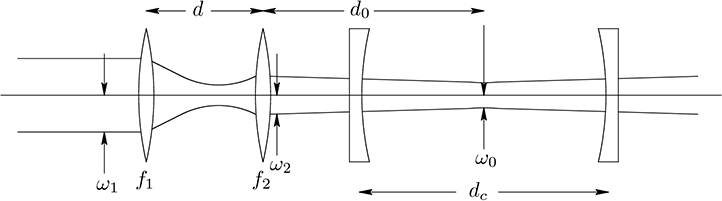

Figure 2.16 on pg. 32 of Nagourney.

1. Determine $w_0$ and $z_0$ from the cavity equations.
2. Given $d_0$ , the distance from waist to lens 2, determine $w_2$ using $w_2 = w_0 +\left( \frac{d_0}{z_R} \right)^2$
3. Given input spot size $w_1$, find two lenses whose focal lengths are in ratio $w_1/w_2$.
4. Separate lenses by slightly more than $f_1 + f_2$ so waist is at center of cavity.


In [1]:
# Gaussian beam & cavities jupyter notebook code. Written by Amar.
# Updated and annotated by Kristen and Shira, Winter 2020

# All lengths in mm

from __future__ import division, print_function
import numpy as np
from numpy import sin,cos,tan,arctan,pi,sqrt,abs
import matplotlib.pyplot as plt
import numpy.linalg as npl
from scipy import optimize
from functools import partial

speed_of_light = 3e11   # mm/s
I = np.mat(np.eye(2))   # identity matrix
lamda = 0.915e-3        # mm

class OpticalElement:
    def __init__(self,T = np.matrix(np.identity(2)),label=''):
        self.T = I
        self.label = label

class FreeSpace(OpticalElement):
    def __init__(self,d,label=''):
        self.T = np.matrix( [[1,d],[0,1]] )
        self.label = label

class ThinLens(OpticalElement):
    def __init__(self,f,label=''):
        self.T = np.matrix( [[1,0],[-1/f,1]] )

class Cascade(OpticalElement):
    def __init__(self,cascade_list,label=''):
        """ Matrix multiple the list of ABCD matrices cascade_list.
            cascade_list should be a list of OpticalElement
            Optical elements should be listed in order from left to right, inputs at left """
        self.assembly = cascade_list
        self.label = label
        self.T = I
        for element_i in cascade_list: self.T = element_i.T * self.T

def propagate(T,q):
    """ Propagates complex gaussian beam parameter q through ABCD matrix T using q_new = (Aq+B)/(Cq+D) """
    return (T[0,0]*q + T[0,1])/(T[1,0]*q + T[1,1])

def z_R(w0): #Rayleigh range
    return pi*w0**2/lamda

def q(z,w0): # complex beam parameter q
    return z + 1j*z_R(w0)

def R(q): #radius of curvature of wavefront
    return 1/((1/q).real)

def w(q): #spot size
    return sqrt(lamda*q.imag/pi) * abs(q)/q.imag

def waist(q): #Gaussian beam waist size
    Zr = q.imag
    return sqrt(lamda*Zr/pi)

def eigenmode(T):
    # gaussian beam q parameter equation for 1 round trip/standing wave, i.e. q_new = q: Cq^2+(D-A)q-B = 0
    a,b,c,d = np.array(T.flatten())[0]
    return np.roots([c,d-a,-b]) #returns q




## Calculation of cavity eigenmode

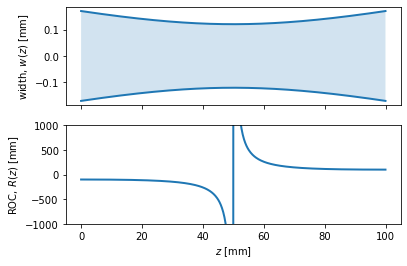

Eigenmode properties
--------------------
At input mirror of cavity:
	 q_in = (-49.97+50j)
	 1/q_in = (-0.01-0.01j)

Waist location = left mirror + 49.87 mm
Waist radius = 0.1207 mm
q_waist = 49.8748 + 50.0002 j

ROC at left mirror = -99.99999999999956 mm
Beam radius at left mirror = 0.1706188604679236 mm

ROC at right mirror = 99.99999999999956 mm
Beam radius at right mirror = 0.17061886046792846 mm

FSR = 1.501 GHz
Transverse mode spacing = 750.1 MHz


In [2]:

## Cavity eigenmode calculation: confocal cavity
# Note: if L=R1=R2 exactly, the code will not be able to find a q_stable. Add a tiny offset.

L = 99.95      # spacer length in mm
R1 = 100.0    # ROC for left mirror in mm
R2 = 100.0    # ROC for right mirror in mm

system = Cascade( [FreeSpace(L),
                    ThinLens(R2/2.0),
                    FreeSpace(L),
                    ThinLens(R1/2.0)] )

q_stable = eigenmode(system.T)       # = -z0 + 1j*z_R

if len(q_stable)==0 or q_stable[0].imag==0: print("Unstable cavity")
else:
    q_in = q_stable[0]
    z = np.linspace(0,L,500)

    q_array = np.array( [propagate( FreeSpace(zi).T, q_in )  for zi in z] )
    w_array = w(q_array)

    gp = np.arctan2(q_array.real,q_array.imag)
    diff_guoy_phase = (gp[z==L] - gp[z==0])[0]
    free_spectral_range = speed_of_light/(2*L)

    fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
    axes[0].plot(z,w_array,z,-w_array,color='C0',lw=2)
    axes[0].fill_between(z,w_array,-w_array,lw=2,alpha=0.2)
    axes[1].plot(z,R(q_array),lw=2)
    axes[1].set_ylim(-1000,1000)
    axes[0].set_ylabel("width, $w(z)$ [mm]")
    axes[1].set_ylabel("ROC, $R(z)$ [mm]")
    axes[1].set_xlabel("$z$ [mm]")
    plt.show()

    print( "Eigenmode properties" )
    print( ''.join(["-"]*20) )
    print("At input mirror of cavity:")
    print( "\t q_in = {}".format(np.round(q_in,2)) )
    print( "\t 1/q_in = {}".format(np.round(1/q_in,4)) )
    print()
    waist_location = z[w_array == w_array.min()][0]
    waist_radius =  w_array.min()
    rayleigh_range = np.pi*waist_radius**2/lamda
    print( "Waist location = left mirror + {:.4} mm".format( z[w_array == w_array.min()][0] ) )
    print( "Waist radius = {:.4} mm".format( w_array.min() ) )
    print( "q_waist = %.4f + %.4f j"%(waist_location,rayleigh_range))
    print()
    print( "ROC at left mirror = {:4} mm".format( R(q_array[0]) ) )
    waist_left = w(q_array[0])
    print( "Beam radius at left mirror = {:4} mm".format( w(q_array[0]) ) )
    print()
    print( "ROC at right mirror = {:4} mm".format( R(q_array[z==L])[0] ) )
    print( "Beam radius at right mirror = {:4} mm".format( w(q_array[z==L])[0] ) )
    print()
    print( "FSR = {:.4} GHz".format(free_spectral_range/1e9))
    print( "Transverse mode spacing = {:.4} MHz".format(diff_guoy_phase*free_spectral_range/1e6/pi))

q_target = waist_location +1j*rayleigh_range


## Single lens mode-matching

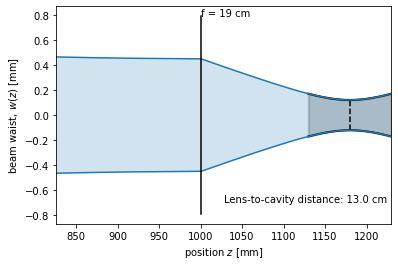

In [4]:
# change for measured beam radius of collimated laser beam
w_laser = 0.5 #collimated beam waist


q0 = q(0,w_laser)

def q_at_cavity(f):
    lens = ThinLens(f)
    q_p = propagate(lens.T,q0) # right after lens
    distance_to_new_waist = -q_p.real
    distance_to_cavity = distance_to_new_waist-R1/2
    travel = FreeSpace(distance_to_cavity)
    return propagate(travel.T,q_p) # q at front of cavity

# find differences in radius of curvature
q_target = q_stable[0]
test_fs = np.logspace(-1,3,1000)
diffs = q_at_cavity(test_fs).imag-q_target.imag

# pick out best lens
f_index = list(np.abs(diffs)).index(np.min(np.abs(diffs)))
f = test_fs[f_index]


# adjust the focal length until the mode matching looks good. 
#f = 150 #len focal length

# get approximate ideal position of lens
lens = ThinLens(f)
q_p = propagate(lens.T,q0)
distance_to_new_waist = -q_p.real
d2 = distance_to_new_waist-R1/2


# draw everything
q_laser = q(-1000,w_laser)

z_sects = [0,1000,d2,L]
num_sects = len(z_sects)
num_points = 1000
optics = [I,ThinLens(f),I]

zs = []
ws = []

q_start = q_laser

for i in range(len(optics)):
    for j in range(num_points):
        new_z = z_sects[i+1]/num_points*j
        zs.append(new_z+sum(z_sects[0:i+1]))
        new_q = propagate(Cascade([optics[i],FreeSpace(new_z)]).T,q_start)
        ws.append(w(new_q))
    q_start = new_q


q_req = q_stable[0]
z_req = np.linspace(0,L,500)
q_req_array = np.array( [propagate( FreeSpace(zi).T, q_req )  for zi in z] )
w_req = w(q_req_array)

z_req = z_req+sum(z_sects)-L

fig = plt.figure()
ax1=fig.add_subplot(111)

ax1.plot([sum(z_sects)-L/2,sum(z_sects)-L/2],[-waist_radius,waist_radius],'--k')
ax1.plot(z_req,w_req,color='k',lw=2)
ax1.plot(z_req,[-1.0*w for w in w_req],color='k',lw=2)
ax1.fill_between(z_req,w_req,-w_req,lw=2,alpha=0.2,color='k')


ax1.plot(zs,ws,color='C0')
ax1.plot(zs,[-w for w in ws],color='C0')
ax1.fill_between(zs,ws,[-w for w in ws],lw=2,alpha=0.2)

ax1.set_xlim([1000-z_R(w_laser)/4,zs[-1]])

lens_height = max(ws)
ax1.plot([z_sects[1],z_sects[1]],[-lens_height,lens_height],'k')
ax1.text(z_sects[1],lens_height,'f = %i cm'%(f/10.0))

ax1.text(0.5,0.1,"Lens-to-cavity distance: %.1f cm"%(d2*0.1),transform=ax1.transAxes)

ax1.set_ylabel("beam waist, $w(z)$ [mm]")
ax1.set_xlabel("position $z$ [mm]")
plt.show()


## Two lens mode-matching

initial laser beam radius = 0.31 mm
necessary focal length ratio = 0.468


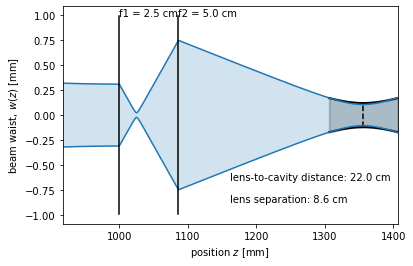

In [3]:
## Modematching to confocal cavity with two lenses: Nagourney's method
# Method from "Quantum Electronics for Atomic Physics" by Warren Nagourney
# See figure 2.16 on pg. 32 for definitions of f1,f2,d2, etc.

# change for measured beam radius of collimated laser beam
w_laser = 0.31 #measured laser beam radius
# change for desired distance between second lens and cavity (in Nagourney this is d0-dc/2 where dc = L in this code)
d2 = 220
# change for desired focal length of first lens
f1 = 25.4



def mode_matching_nagourney(w_laser,q_target,distance_from_cavity_input=50):
    d0 = (q_target.real) + distance_from_cavity_input
    w0 = sqrt( lamda*q_target.imag/pi )    # cavity waist
    w2 = w0 * sqrt(1 + (d0/q_target.imag)**2)      # beam size at exit of lens2
    f_ratio = w_laser/w2
    return d0, f_ratio


q_laser = q(-1000,w_laser)
print( "initial laser beam radius = {} mm".format(np.round(w_laser,3)) )
d0,f_ratio = mode_matching_nagourney(w_laser,q_target,distance_from_cavity_input = d2)
print("necessary focal length ratio = {}".format(np.round(f_ratio,3)))

f2 = 10*np.round(0.1*f1/f_ratio) #round to some tens of cm so that it corresponds to a lens that might actually exist. 


# Nagourney's method says to "Separate lenses by slightly more than f1+f2 so waist is at center of cavity". 
# Play with the "slightly more" until it looks good.
lens_separation = f1+f2+11


z_sects = [0,1000,lens_separation,d2,L]
num_sects = len(z_sects)
num_points = 1000

optics = [I,ThinLens(f1),ThinLens(f2),I]

zs = []
ws = []

q_start = q_laser

for i in range(len(optics)):
    for j in range(num_points):
        new_z = z_sects[i+1]/num_points*j
        zs.append(new_z+sum(z_sects[0:i+1]))
        new_q = propagate(Cascade([optics[i],FreeSpace(new_z)]).T,q_start)
        ws.append(w(new_q))
    q_start = new_q


q_req = q_stable[0]
z_req = np.linspace(0,L,500)
q_req_array = np.array( [propagate( FreeSpace(zi).T, q_req )  for zi in z] )
w_req = w(q_req_array)

z_req = z_req+sum(z_sects)-L

fig = plt.figure()
ax1=fig.add_subplot(111)

ax1.plot([sum(z_sects)-L/2,sum(z_sects)-L/2],[-waist_radius,waist_radius],'--k')
ax1.plot(z_req,w_req,color='k',lw=2)
ax1.plot(z_req,[-1.0*w for w in w_req],color='k',lw=2)
ax1.fill_between(z_req,w_req,-w_req,lw=2,alpha=0.2,color='k')


ax1.plot(zs,ws,color='C0')
ax1.plot(zs,[-w for w in ws],color='C0')
ax1.fill_between(zs,ws,[-w for w in ws],lw=2,alpha=0.2)

ax1.set_xlim([1000-z_R(w_laser)/4,zs[-1]])

lens_height = max(ws)
ax1.plot([z_sects[1],z_sects[1]],[-lens_height,lens_height],'k')
ax1.plot([z_sects[1]+z_sects[2],z_sects[1]+z_sects[2]],[-lens_height,lens_height],'k')
ax1.text(z_sects[1],lens_height,'f1 = %0.1f cm'%(f1/10.))
ax1.text(z_sects[1]+z_sects[2],lens_height,'f2 = %0.1f cm'%(f2/10.))

ax1.text(0.5,0.1,'lens separation: %0.1f cm'%(lens_separation/10.0),transform=ax1.transAxes)
ax1.text(0.5,0.2,'lens-to-cavity distance: %0.1f cm'%(d2/10.0),transform=ax1.transAxes)



ax1.set_ylabel("beam waist, $w(z)$ [mm]")
ax1.set_xlabel("position $z$ [mm]")
plt.show()

## Single lens mode-matching